In [1]:
%cd ..

/mnt/c/Users/XCB/OneDrive - Van Oord/Documents/thesis/code


In [2]:
import geopandas as gpd
from atl_module.geospatial_utils.raster_interaction import query_from_lines
import matplotlib.pyplot as plt
import numpy as np
from atl_module.plotting import set_size
from scipy.stats import norm
from atl_module.kalman import simple_kalman

In [3]:
transect_number = 12

In [4]:
tracklines = gpd.read_file("../data/test_sites/florida_keys/tracklines/")
trackline_test = tracklines.geometry[transect_number]
kriging_points = gpd.read_file("../data/test_sites/florida_keys/kriging_pts/")
utm_line = tracklines.to_crs(kriging_points.crs).geometry[transect_number]
clipped_kriging_points = kriging_points.clip(utm_line.buffer(50)).to_crs("EPSG:4326")
clipped_kriging_points

,Y,X,Z,geometry
44,2.737802e+06,490820.762659,-2.424307,POINT (-81.09079 24.75481)
1395,2.737804e+06,490820.621875,-2.424307,POINT (-81.09079 24.75483)
1440,2.737815e+06,490819.433557,-2.365247,POINT (-81.09080 24.75493)
1866,2.737820e+06,490819.009097,-2.428361,POINT (-81.09080 24.75497)
1151,2.737909e+06,490809.954485,-2.478913,POINT (-81.09089 24.75578)
...,...,...,...,...
828,2.726201e+06,491957.181327,-6.542243,POINT (-81.07948 24.65004)
1019,2.726357e+06,491941.192872,-6.314722,POINT (-81.07964 24.65145)
648,2.726401e+06,491936.926859,-6.628085,POINT (-81.07968 24.65186)
384,2.726405e+06,491936.580714,-6.704979,POINT (-81.07968 24.65189)


In [5]:
x, y, truth_values = query_from_lines(
    trackline_test, "../data/test_sites/florida_keys/in-situ-DEM/truth.vrt", band=1
)
x, y, bilinear_gebco = query_from_lines(
    trackline_test, "../data/test_sites/florida_keys/bilinear.tif", band=1
)
x, y, kalman = query_from_lines(
    trackline_test, "../data/test_sites/florida_keys/kalman_updated.tif", band=1
)
x, y, kalman_uncertainty = query_from_lines(
    trackline_test, "../data/test_sites/florida_keys/kalman_updated.tif", band=2
)
x, y, kriging = query_from_lines(
    trackline_test, "../data/test_sites/florida_keys/kriging_output.tif", band=1
)
x, y, kriging_uncertainty = query_from_lines(
    trackline_test, "../data/test_sites/florida_keys/kriging_output.tif", band=2
)

In [6]:
xindex = np.arange(0, len(kalman))

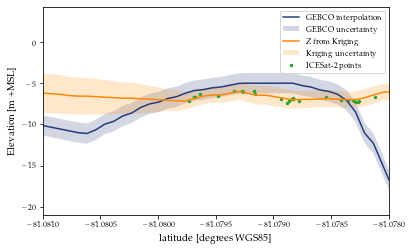

In [7]:
fig, ax = plt.subplots(figsize=set_size(fraction=1))
ax.plot(x, bilinear_gebco, label="GEBCO interpolation")
ax.fill_between(
    x,
    bilinear_gebco + np.sqrt(1.5),
    bilinear_gebco - np.sqrt(1.5),
    alpha=0.2,
    label="GEBCO uncertainty",
)
ax.plot(x, kriging, label="Z from Kriging")
ax.fill_between(
    x,
    kriging + np.sqrt(kriging_uncertainty),
    kriging - np.sqrt(kriging_uncertainty),
    alpha=0.2,
    label='Kriging uncertainty'
)
# ax.ca
ax.scatter(clipped_kriging_points.geometry.x, clipped_kriging_points.Z,label='ICESat-2 points',s=6)
# ax.plot(x, truth_values, label="truth value")
ax.legend()
ax.set_xlim(-81.081,-81.078)
ax.set_xlabel('latitude [degrees WGS85]')
ax.set_ylabel('Elevation [m +MSL]')
fig.savefig('../document/figures/methodology-kriging-output.pdf')

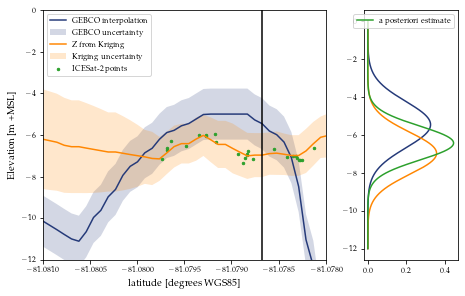

In [8]:
fig, (ax1,ax2) = plt.subplots(figsize=set_size(fraction=1.2),ncols=2,gridspec_kw={'width_ratios': [3, 1]})
ax1.plot(x, bilinear_gebco, label="GEBCO interpolation")
ax1.fill_between(
    x,
    bilinear_gebco + np.sqrt(1.5),
    bilinear_gebco - np.sqrt(1.5),
    alpha=0.2,
    label="GEBCO uncertainty",
)
ax1.plot(x, kriging, label="Z from Kriging")
ax1.fill_between(
    x,
    kriging + np.sqrt(kriging_uncertainty),
    kriging - np.sqrt(kriging_uncertainty),
    alpha=0.2,
    label='Kriging uncertainty'
)
# ax.ca
ax1.scatter(clipped_kriging_points.geometry.x, clipped_kriging_points.Z,label='ICESat-2 points',s=6)
# ax.plot(x, truth_values, label="truth value")
ax1.legend()
ax1.set_xlim(-81.081,-81.078)
ax1.set_xlabel('latitude [degrees WGS85]')
ax1.set_ylabel('Elevation [m +MSL]')
ax1.set_ylim((-12,0))


# get variables for subplot
# first pick an index to index into the arrays at a single point
i = 10

ax1.axvline(x[i],c='black')
varcr = kriging_uncertainty[i]
zkrig = kriging[i]
gebcoelev = bilinear_gebco[i]
# get the kalman updated values
znew,sigmanew = simple_kalman(gebcoelev,1.5,zkrig,varcr)

# calculate the pdf curves for these measurements
x_pdf=np.linspace(*ax1.get_ylim(),1000)
y_gebco=norm(loc=gebcoelev,scale=np.sqrt(1.5)).pdf(x_pdf)
y_kriging = norm(loc=zkrig,scale=varcr).pdf(x_pdf)
y_kalman = norm(loc=znew,scale=sigmanew).pdf(x_pdf)

# plot them all
ax2.plot(y_gebco,x_pdf)
ax2.plot(y_kriging,x_pdf)
ax2.plot(y_kalman,x_pdf,label='a posteriori estimate')
ax2.legend()
fig.savefig('../document/figures/methodology-kalman-updating.pdf')

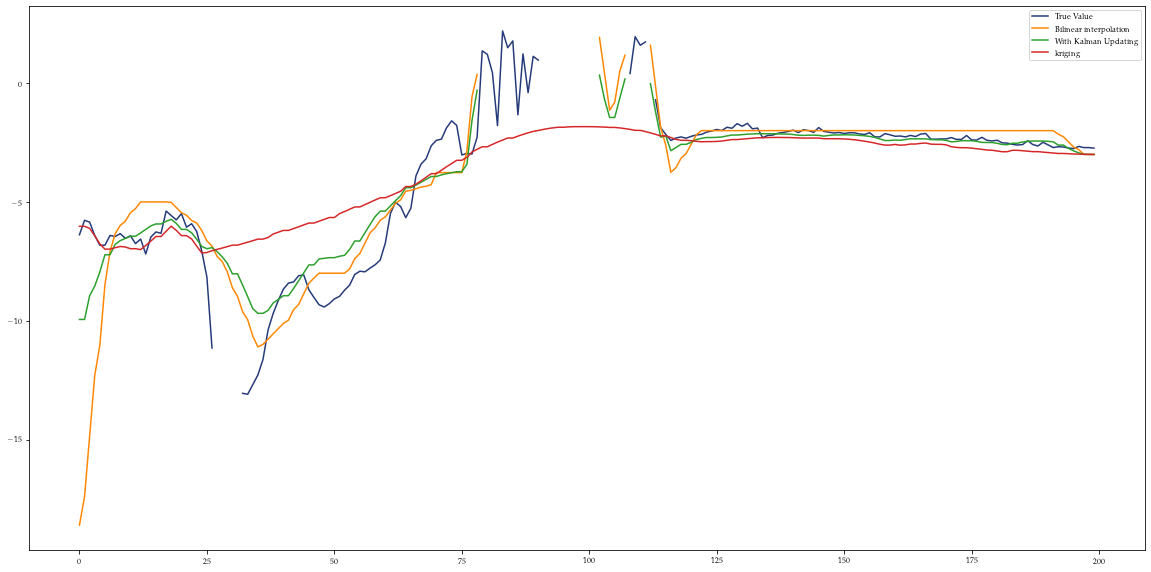

In [9]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(truth_values, label="True Value")
ax.plot(bilinear_gebco, label="Bilinear interpolation")
ax.plot(kalman, label="With Kalman Updating")
ax.plot(kriging, label="kriging")
ax.legend()

# 3d plot experiment

In [10]:
import rasterio as rio

In [11]:
with rio.open('../data/test_sites/oahu1/kriging_output.tif') as kriging:
    zvals_kr = kriging.read(1)
    uncertainty = kriging.read(2)
    height = zvals_kr.shape[0]
    width = zvals_kr.shape[1]
    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xs, ys = rio.transform.xy(kriging.transform, rows, cols)
    xs= np.array(xs)
    ys = np.array(ys)

In [12]:
kr_points = gpd.read_file('../data/test_sites/oahu1/kriging_pts/')

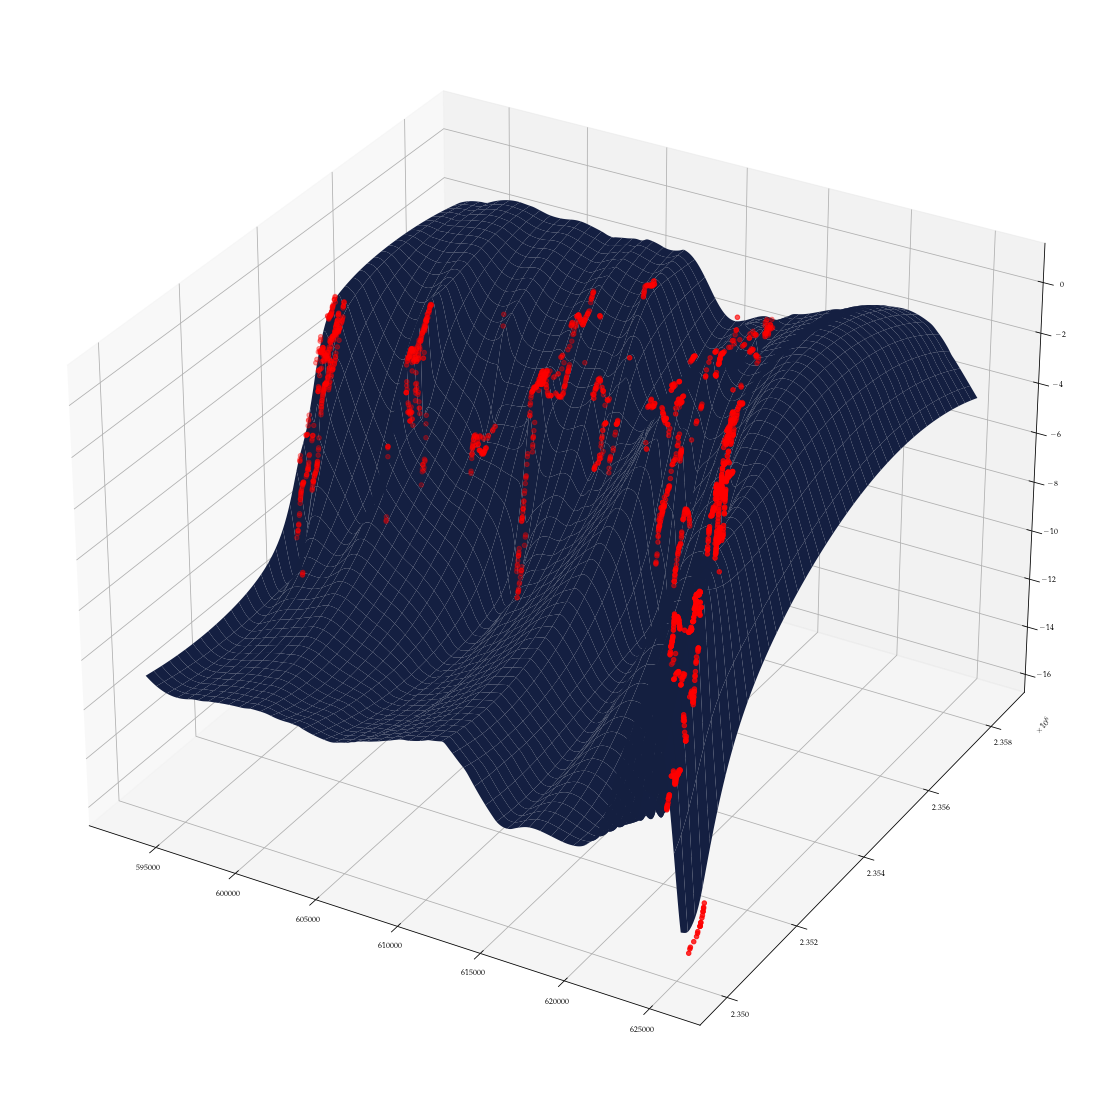

In [13]:

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(xs,ys,zvals_kr)
# ax.plot_surface(xs,ys,uncertainty,alpha=0.2)
ax.scatter(kr_points.geometry.x,kr_points.geometry.y,kr_points.Z,c='red')